In [1]:
import numpy as np
import xml.etree.ElementTree as ET
from pricing import ACT_365, DiscountingCurve, EquityForwardCurve, Curve
import lets_be_rational.LetsBeRational as lbr
from numpy import log, exp,sqrt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import time
from matplotlib import ticker 
from localvol import A_i_matrix,alpha_i_vector,beta_i_vector,gamma_i_vector,set_limits,backward_euler_method,call_options_pricer, LocalVolatilityCurve, from_price_to_vola,back_coordinates, new_LV_points,loss_function

zero interest rate time grid [0.00000000e+00 2.73972603e-03 5.47945205e-03 8.21917808e-03
 2.46575342e-02 4.38356164e-02 6.30136986e-02 9.31506849e-02
 1.72602740e-01 2.57534247e-01 3.42465753e-01 4.24657534e-01
 5.15068493e-01 5.91780822e-01 6.76712329e-01 7.31506849e-01
 7.53424658e-01 9.83561644e-01 1.00547945e+00 1.23287671e+00
 1.47945205e+00 1.72602740e+00 1.98082192e+00 2.01095890e+00
 2.23013699e+00 3.00821918e+00 4.00821918e+00 5.00821918e+00
 6.00821918e+00 7.00821918e+00 8.01369863e+00 9.01095890e+00
 1.00109589e+01 1.10109589e+01 1.20136986e+01 1.30191781e+01
 1.40164384e+01 1.50136986e+01 1.60164384e+01 1.70164384e+01
 1.80164384e+01 1.90219178e+01 2.00191781e+01 2.10191781e+01
 2.20191781e+01 2.30191781e+01 2.40273973e+01 2.50246575e+01
 2.60219178e+01 2.70219178e+01 2.80246575e+01 2.90246575e+01
 3.00301370e+01 3.10273973e+01 3.20273973e+01 3.30273973e+01
 3.40273973e+01 3.50273973e+01 3.60328767e+01 3.70301370e+01
 3.80301370e+01 3.90301370e+01 4.00328767e+01 5.00383562

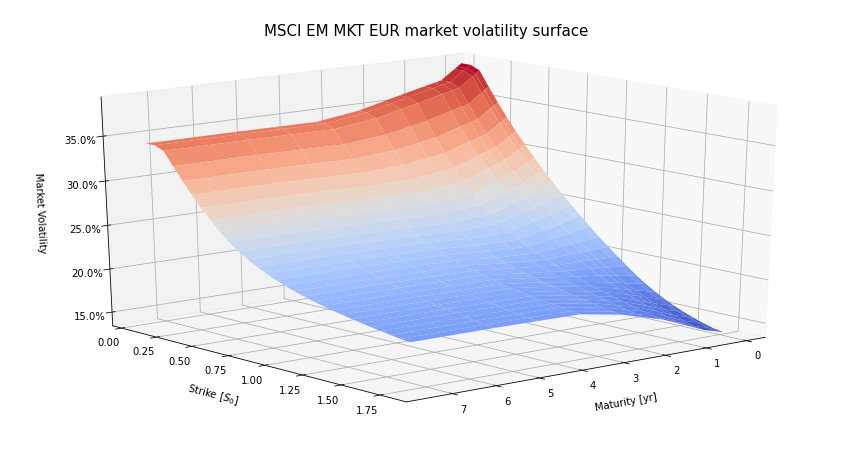

In [2]:
index_equity = [3]

tree = ET.parse('TV_example.xml')
root = tree.getroot()
N_stocks = len(root[3][0][1][1][1][0])
names = np.array([])
for i in range(N_stocks):
    names=np.append(names,root[3][0][1][1][1][0][i].text)
delete_equity = [0,11,12,13,14,15]
names = np.delete(names,delete_equity)
reference_date = float(root[3][1][0][0][2][0].text)

spot_prices = np.zeros(len(index_equity))
j = 0
for i in index_equity:
    if i>=6:
        spot_prices[j] = float(root[3][i+3][0][1][0][0].text)
    else:
        spot_prices[j] = float(root[3][3+i][0][0][1][0].text)
    j = j+1
    
discounts = np.zeros(len(root[3][1][0][0][0][0][0]))
discounts_dates = np.zeros(len(root[3][1][0][0][0][0][0]))
for i in range(len(root[3][1][0][0][0][0][0])):
    discounts_dates[i] = float(root[3][1][0][0][0][0][0][i].text)
    discounts[i] = float(root[3][1][0][0][0][1][0][i].text)
D = DiscountingCurve(reference=reference_date, discounts=discounts, dates=discounts_dates, act="365")

F = []
max_dates = np.array([10])
index = 0
for i in index_equity:
    if i>=6:
        repo_dates = np.array([reference_date+1, max(max_dates)])
        repo_rates = np.zeros(2)
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    else:
        repo_dates = np.zeros(len(root[3][3+i][0][0][0][0][0]))
        repo_rates = np.zeros(len(root[3][3+i][0][0][0][1][0]))
        for j in range (len(root[3][3+i][0][0][0][0][0])):
            repo_dates[j] = float(root[3][3+i][0][0][0][0][0][j].text)
            repo_rates[j] = float(root[3][3+i][0][0][0][1][0][j].text)
        max_dates = np.append(max_dates,max(repo_dates))
        F.append(EquityForwardCurve(reference=reference_date, discounting_curve=D, repo_dates=repo_dates,repo_rates=repo_rates, spot=spot_prices[index],act="360"))
    index = index+1
F = F[0]

for i in index_equity:
    vola_dates = np.zeros(len(root[3][i+3][1][2][0][0]))
    vola_strikes = np.zeros(len(root[3][i+3][1][2][2][0]))
    for j in range(len(root[3][i+3][1][2][0][0])):
        vola_dates[j] = float(root[3][i+3][1][2][0][0][j].text)
    for j in range(len(root[3][i+3][1][2][2][0])):
        vola_strikes[j] = float(root[3][i+3][1][2][2][0][j].text)
    market_vola = np.zeros(len(root[3][i+3][1][2][0][0])*len(root[3][i+3][1][2][2][0]))
    for k in range (len(market_vola)):
        market_vola[k] = float(root[3][i+3][1][2][1][0][k].text)
    market_vola = np.reshape(market_vola,(len(vola_dates),len(vola_strikes))).T
vola_maturities = ACT_365(vola_dates, reference_date)

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,vola_strikes/spot_prices[0])
 
market_calls = np.zeros(market_vola.shape)
for i in range(len(vola_maturities)):
    for j in range(len(vola_strikes)):
        market_calls[j,i] = lbr.black(1,vola_strikes[j]/F(vola_maturities[i]),market_vola[j,i],vola_maturities[i],1)

Z = market_vola

ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('Market Volatility',labelpad=13)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
plt.savefig("LV_market.pdf",bbox_inches='tight')
plt.show()

In [4]:
from scipy.interpolate import griddata
market_vola.shape, vola_maturities.shape, vola_strikes.shape

((29, 13), (13,), (29,))

In [10]:
vola_strikes

array([ 25.,  50.,  75., 100., 125., 150., 175., 200., 225., 250., 275.,
       300., 325., 350., 375., 400., 425., 450., 475., 500., 525., 550.,
       575., 600., 625., 650., 675., 700., 725.])

In [13]:
grid_x, grid_y = np.mgrid[0:800:100j, 0:20:100j]

In [15]:
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]
points = np.random.rand(1000, 2)
values = func(points[:,0], points[:,1])

In [17]:
grid_z0 = griddata(points, values, (grid_x, grid_y), method={'linear', 'nearest'})

ValueError: Unknown interpolation method {'linear', 'nearest'} for 2 dimensional data

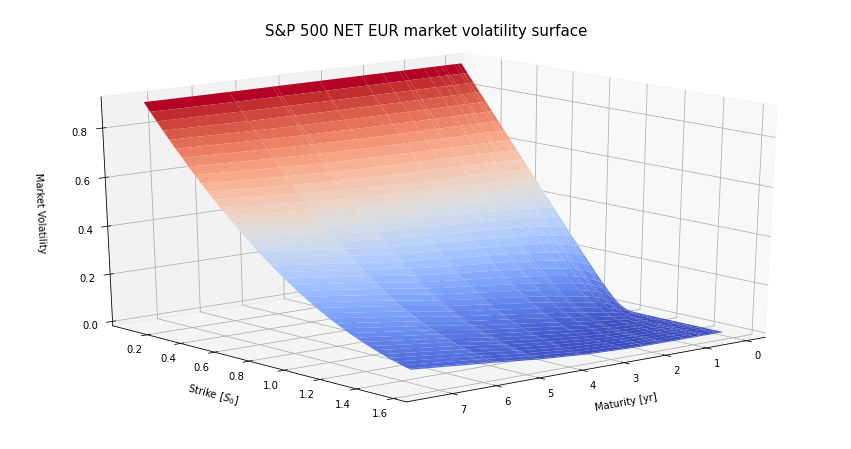

In [3]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, market_calls, cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('Market Volatility',labelpad=13)
plt.title(names[int(index_equity[0]-1)]+' market volatility surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

In [4]:
L_h = 100
L_t = 100
maturities = vola_maturities
h_min, h_max = set_limits(vola_strikes, maturities,F)
d_h = (h_max-h_min)/L_h
h_grid = np.linspace(h_min+d_h,h_max,L_h,endpoint=True)
h_grid = np.insert(h_grid,0,h_min)
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)
print(h_min,h_max)
print(h_grid[0],h_grid[-1])

-2.8293085541384193 2.8293085541384193
-2.8293085541384193 2.8293085541384193


In [8]:
%%time
calls = call_options_pricer(maturities, L_t, h_min, h_max, L_h, F,sigma_LV)

CPU times: user 4min 22s, sys: 8.26 s, total: 4min 30s
Wall time: 2min 15s


In [9]:
calls = calls[0]

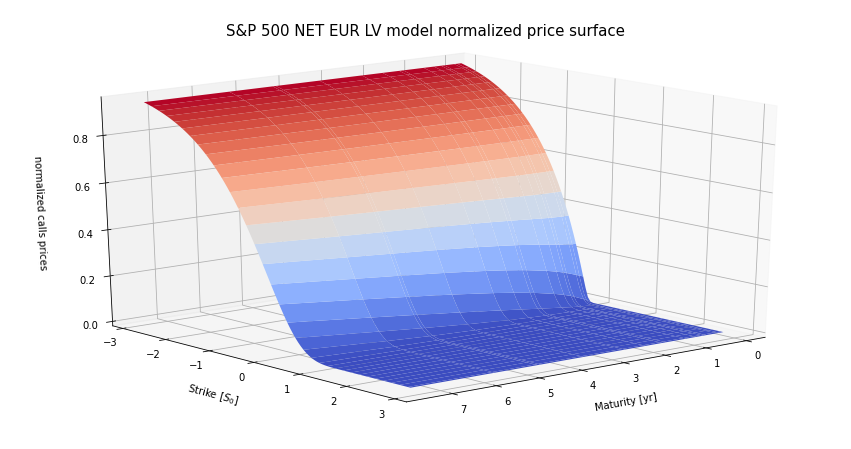

In [10]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,(h_grid) )
Z = calls

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('normalized calls prices',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model normalized price surface',fontsize=15)
ax.view_init(20, 50)
#plt.savefig('gra1hs/ATM_PriceDiff_BS_Market.png')
plt.show()

In [8]:
IV = from_price_to_vola(calls, maturities, h_grid)

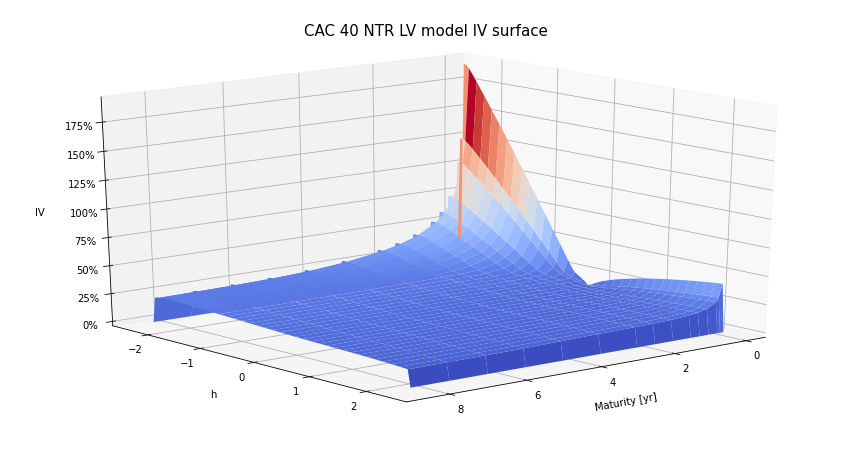

In [9]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,(h_grid) )
Z = IV

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('h',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('IV',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model IV surface',fontsize=15)
ax.view_init(20, 50)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

In [10]:
IV_coord_new = back_coordinates(IV,maturities,F,vola_strikes,h_grid)

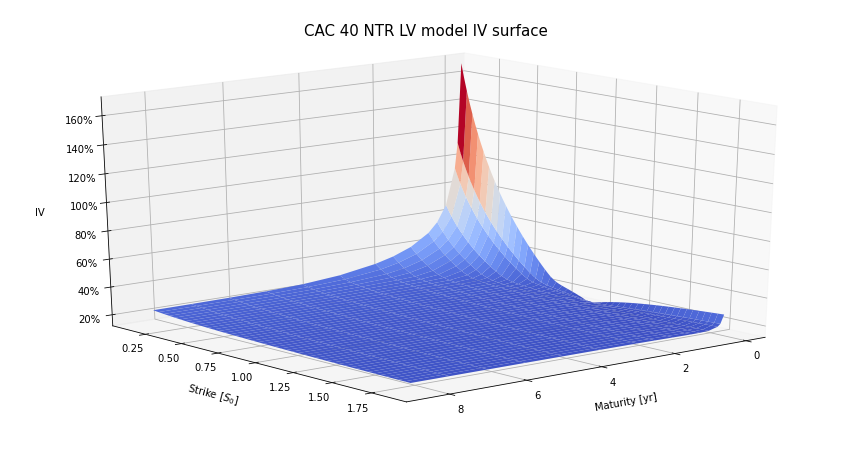

In [11]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,vola_strikes/spot_prices )
Z = IV_coord_new

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('IV',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model IV surface',fontsize=15)
ax.view_init(20, 50)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

In [12]:
new = new_LV_points(new,IV_coord_new,market_vola)

NameError: name 'new' is not defined

NameError: name 'new' is not defined

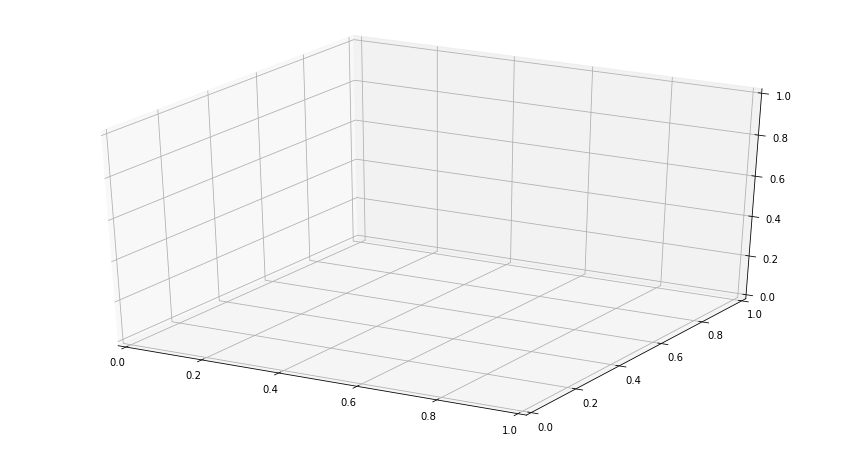

In [13]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
X,Y = np.meshgrid(vola_maturities,vola_strikes/spot_prices )
Z = new

ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

ax.set_ylabel('Strike [$S_0$]',labelpad=15)
ax.set_xlabel('Maturity [yr]',labelpad=15)
ax.set_zlabel('IV',labelpad=13)

plt.title(names[int(index_equity[0]-1)]+' LV model IV surface',fontsize=15)
ax.view_init(20, 50)
ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
plt.show()

In [5]:
L_h = 100
L_t = 300
maturities = vola_maturities
h_min, h_max = set_limits(vola_strikes, maturities,F)
d_h = (h_max-h_min)/L_h
h_grid = np.linspace(h_min+d_h,h_max,L_h,endpoint=True)
h_grid = np.insert(h_grid,0,h_min)
sigma_LV = LocalVolatilityCurve(market_vola,vola_strikes,vola_maturities)
print(h_min,h_max)
print(h_grid[0],h_grid[-1])

-2.8293085541384193 2.8293085541384193
-2.8293085541384193 2.8293085541384193


In [6]:
def figure_stamp(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.savefig("LV_first_"+title+".pdf",bbox_inches='tight')
    plt.show()

In [12]:
import time
def Local_Vol_calibrator(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=200,L_t=300,precision=1,max_iter=15):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    h_min, h_max = -4, 4#set_limits(market_strikes, market_maturities,forward_curve)
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, h_min, h_max, L_h,forward_curve, sigma_LV)
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord,market_volatilities)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60))
        figure_stamp(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

Iterazione: 1 --- Loss function 15.45---time elapsed: 3.8830205490834486


Iterazione: 2 --- Loss function 10.63---time elapsed: 7.795995088900114


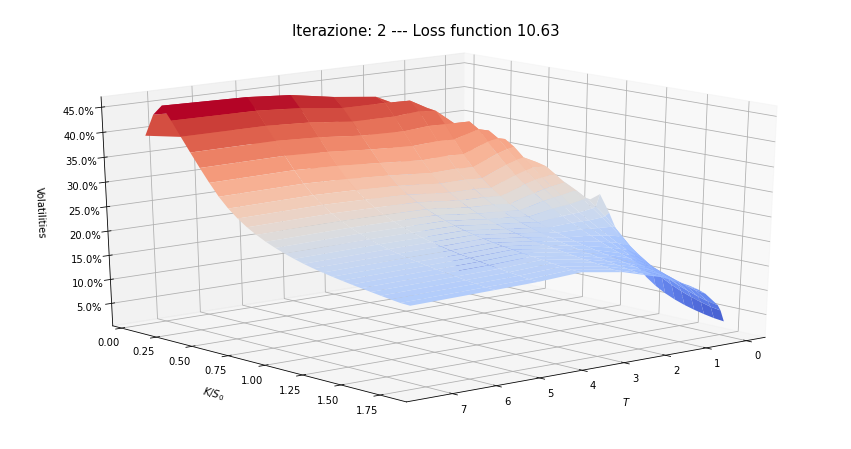

Iterazione: 3 --- Loss function 7.93---time elapsed: 11.694849725450089


Iterazione: 4 --- Loss function 6.28---time elapsed: 15.586471510233363


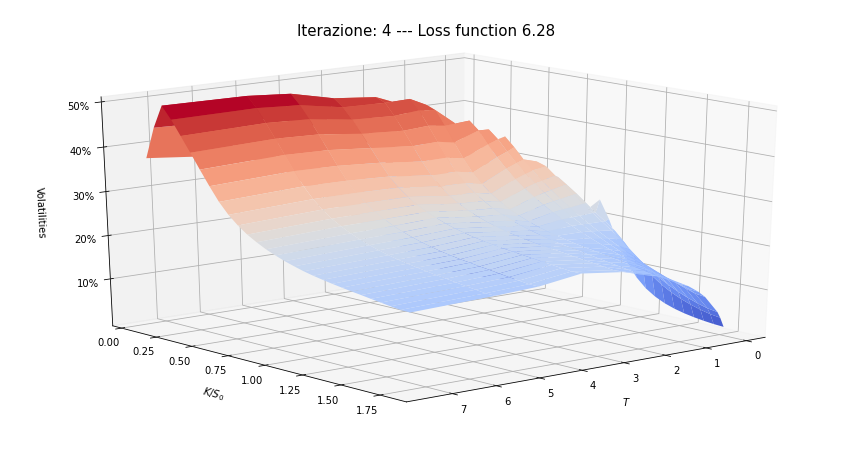

Iterazione: 5 --- Loss function 5.44---time elapsed: 19.494606246583377


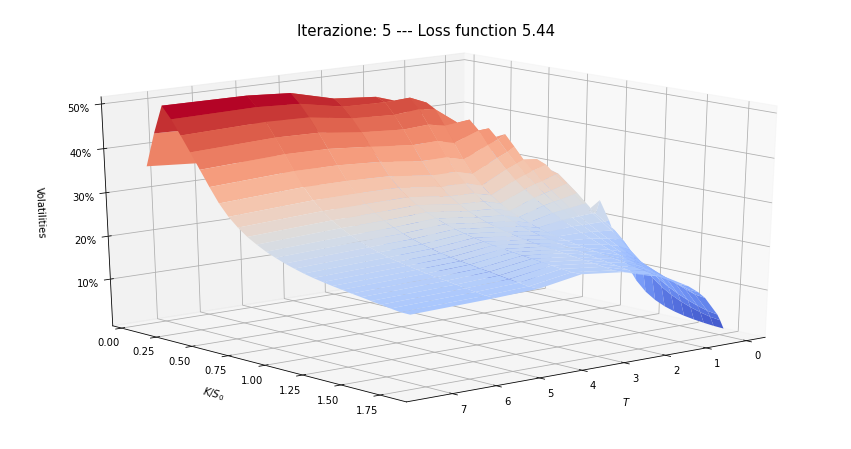

Iterazione: 6 --- Loss function 4.91---time elapsed: 23.40825302660002


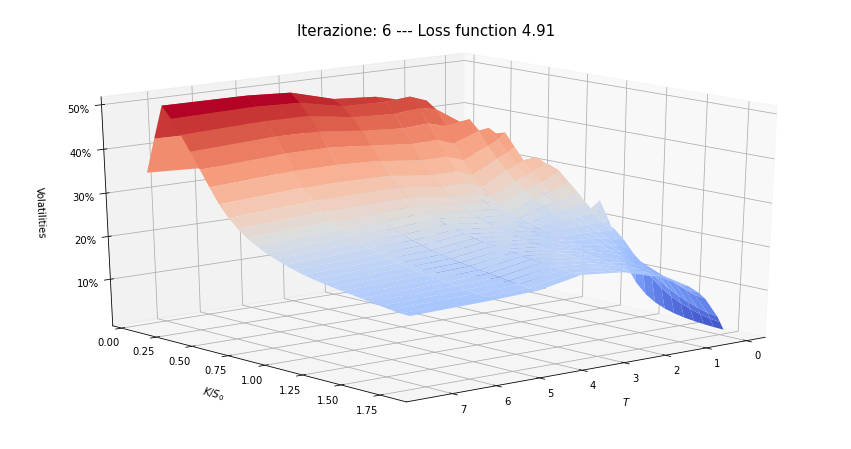

Iterazione: 7 --- Loss function 4.5---time elapsed: 27.40897393618337


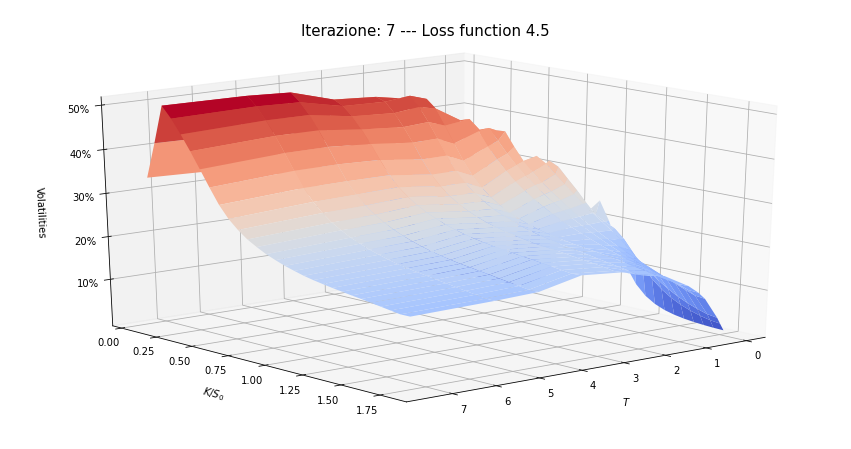

Iterazione: 8 --- Loss function 2.95---time elapsed: 31.342251475183367


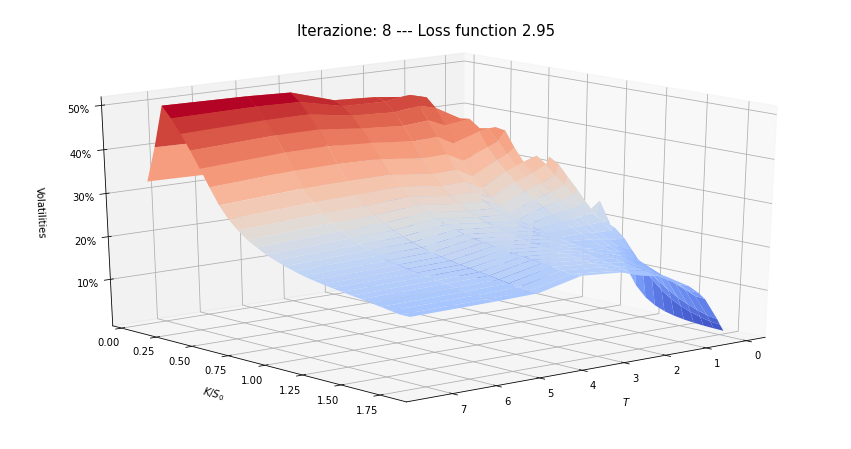

Iterazione: 9 --- Loss function 3.86---time elapsed: 35.28969269136675


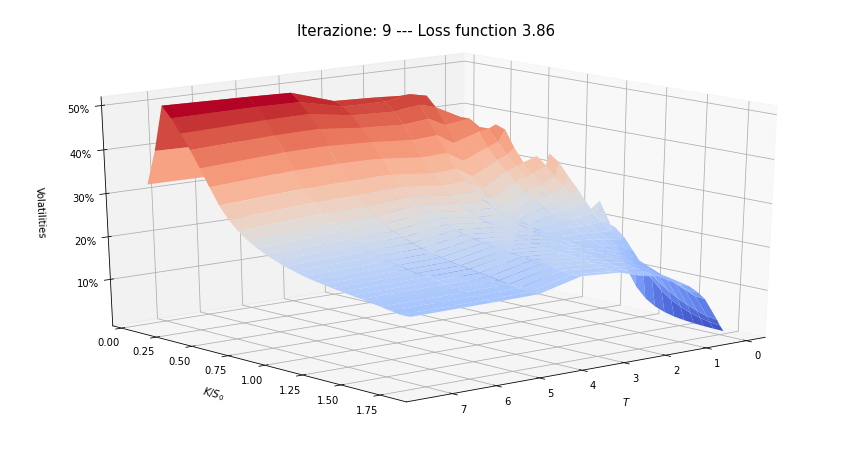

/home/ste/Desktop/Local_volatility/localvol.py:125: RuntimeWarning: overflow encountered in square
  return np.sum((iv_model-market_vola)**2)


Iterazione: 10 --- Loss function inf---time elapsed: 39.234879996400075


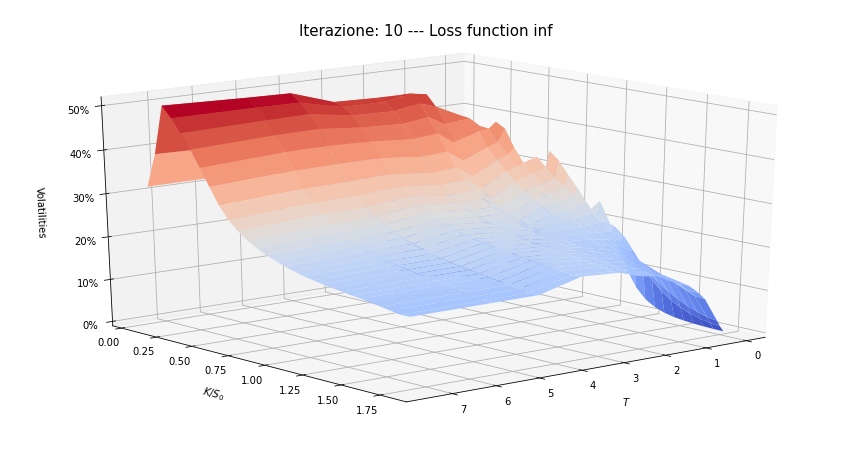

/home/ste/Desktop/Local_volatility/localvol.py:125: RuntimeWarning: overflow encountered in square
  return np.sum((iv_model-market_vola)**2)


Iterazione: 11 --- Loss function inf---time elapsed: 43.16750364568337


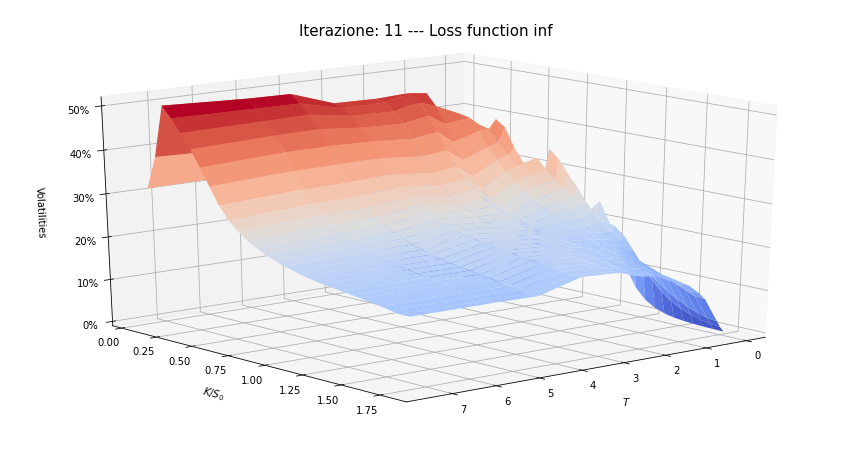

In [ ]:
%%time
a = Local_Vol_calibrator(market_vola,vola_strikes,vola_maturities,F,L_h=150,L_t=150,precision=0.1)

In [9]:
np.save("vol",a)

In [13]:
def forward_volatility(spot_vola_matrix, maturities):
    f_vol = spot_vola_matrix.T[0]
    for i in range(1,len(maturities)):
        f_v = np.sqrt(((spot_vola_matrix.T[i]**2)*maturities[i]-(spot_vola_matrix.T[i-1]**2)*maturities[i-1])/(maturities[i]-maturities[i-1]))
        if i==1:
            f_vol = np.stack((f_vol,f_v),axis=1)
        else:
            f_vol = np.insert(f_vol,len(f_vol.T),f_v,axis=1)
    return f_vol

In [36]:
def figure_stampfw(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.savefig("LV_first_forw_"+title+".pdf",bbox_inches='tight')
    plt.show()

In [37]:
def Local_Vol_calibrator_f(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=200,L_t=300,precision=1,max_iter=15):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    market_vola_forward = forward_volatility(market_volatilities, market_maturities)
    print(np.sum(np.isnan(market_vola_forward)))
    h_min, h_max = set_limits(market_strikes, market_maturities,forward_curve)
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, h_min, h_max, L_h,forward_curve, sigma_LV)
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        IV_coord_forward = forward_volatility(IV_coord, market_maturities)
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord_forward,market_vola_forward)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60))
        print(np.sum(np.isnan(IV_coord_forward)))
        figure_stampfw(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

0
Iterazione: 0---Loss function 29.227321570966957
0


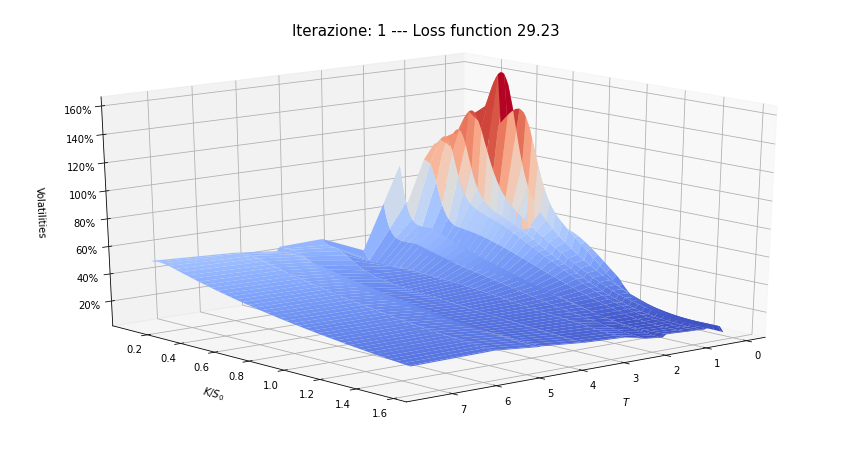

Iterazione: 1---Loss function 20.99681862416986
0


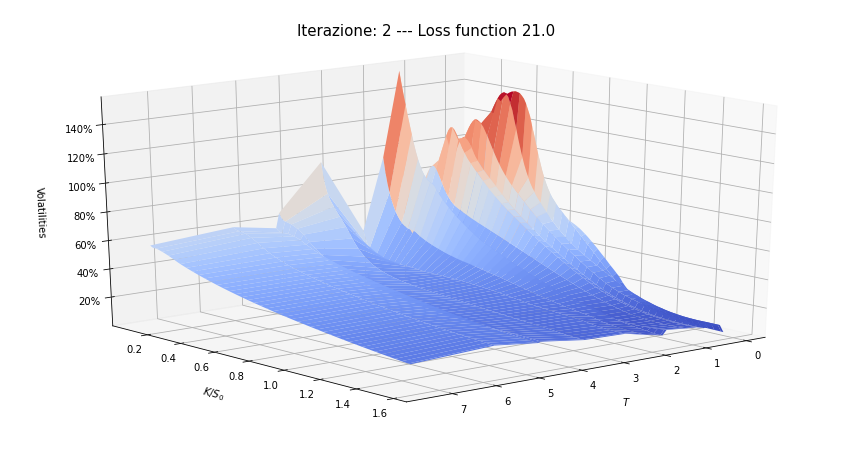

Iterazione: 2---Loss function 20.110552725114797
0


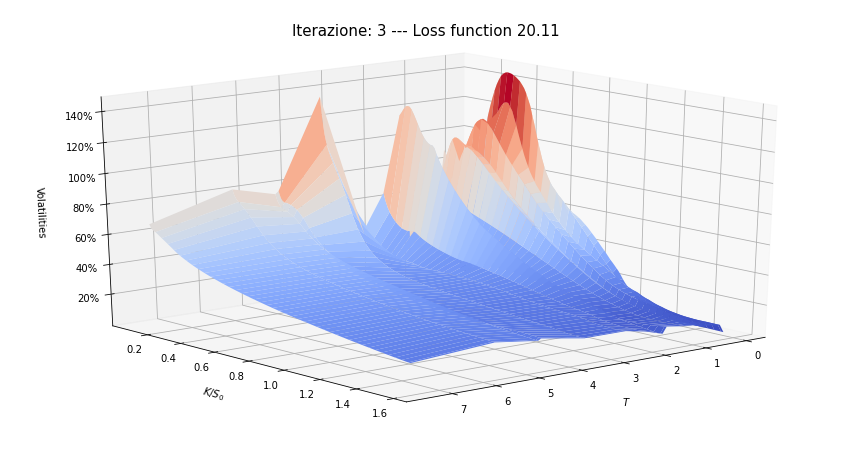

Iterazione: 3---Loss function 20.807215970095243
0


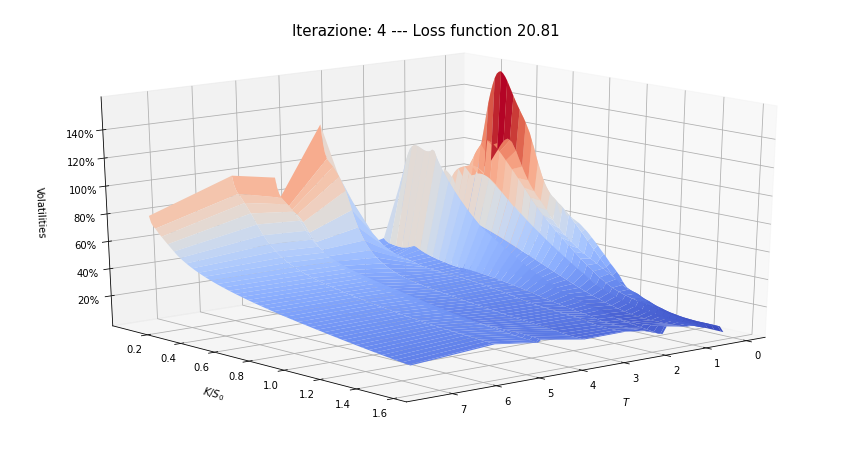

Iterazione: 4---Loss function 21.078922541138745
0


Iterazione: 5---Loss function 21.849966483932924
0


Iterazione: 6---Loss function 22.89211704670527
0


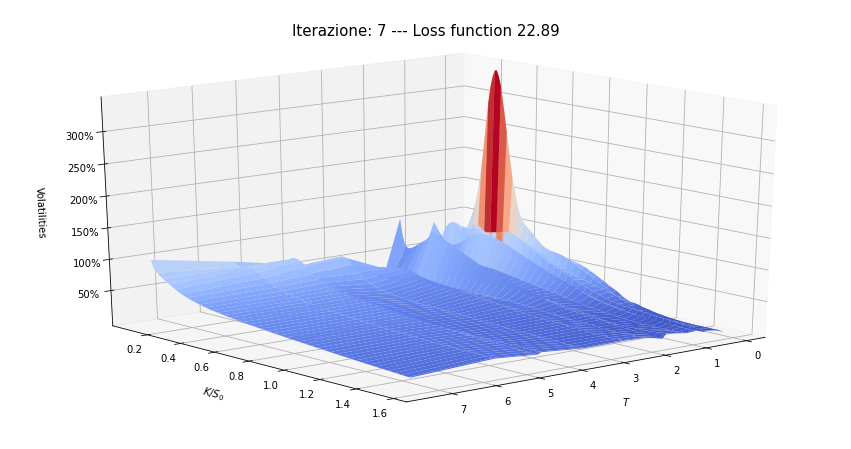

Iterazione: 7---Loss function 24.134137033439774
0


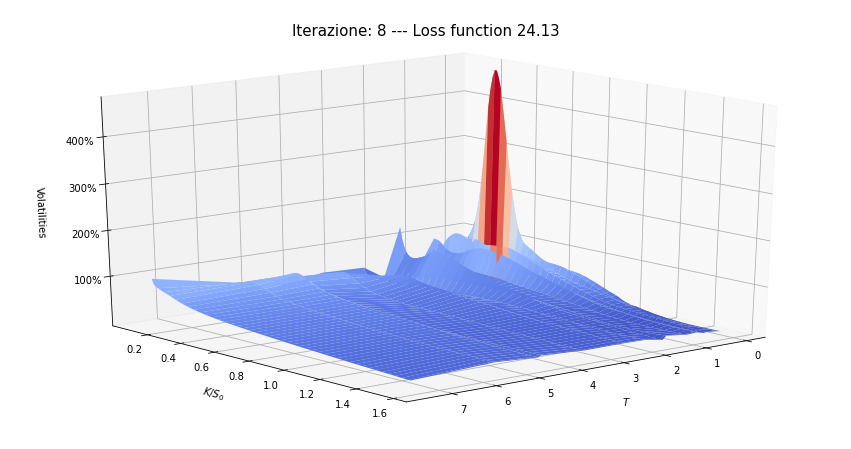

Iterazione: 8---Loss function 25.421425269047052
0


Iterazione: 9---Loss function 26.658913403981146
0


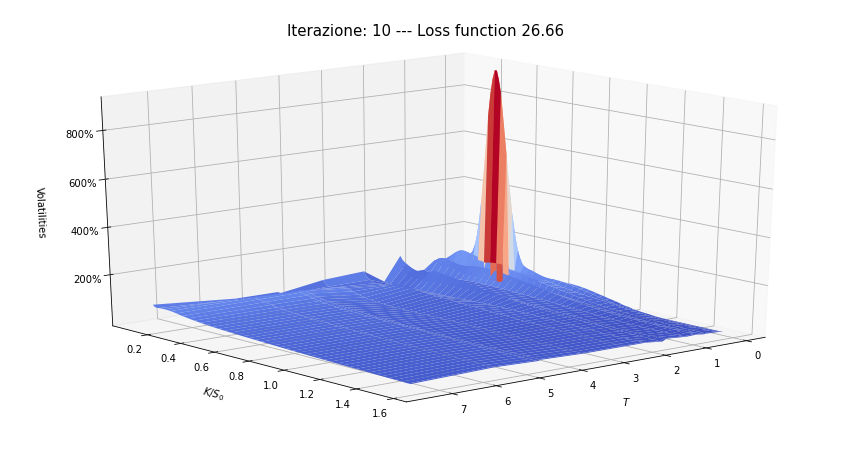

Iterazione: 10---Loss function 27.763087917890758
0


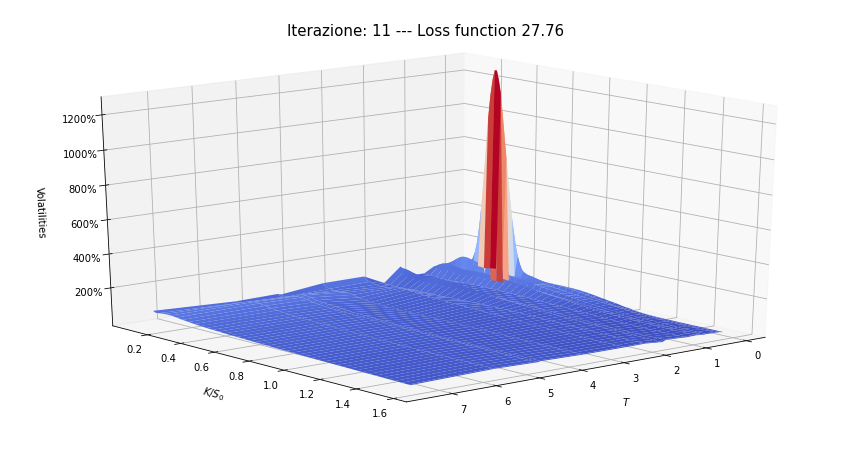

Iterazione: 11---Loss function 28.695010965043537
0


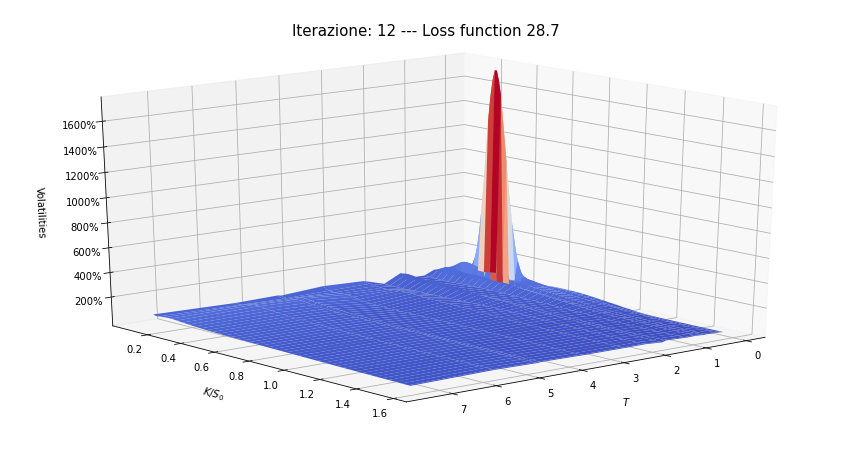

Iterazione: 12---Loss function 29.458576592103693
0


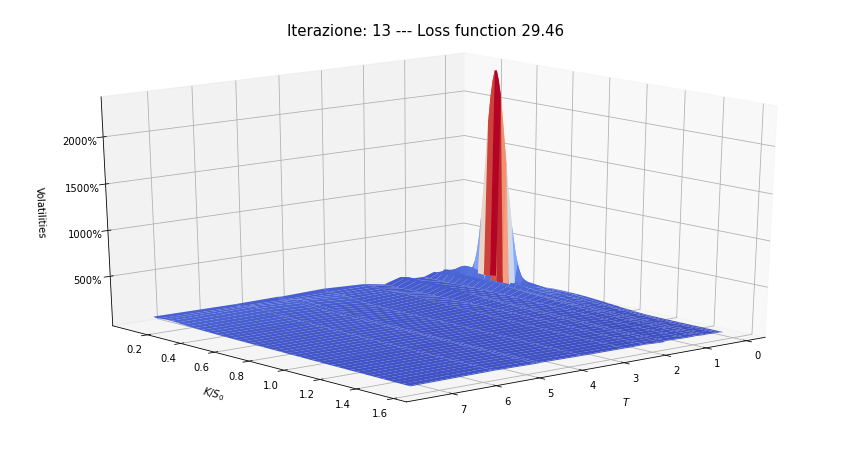

Iterazione: 13---Loss function 30.0887090931101
0


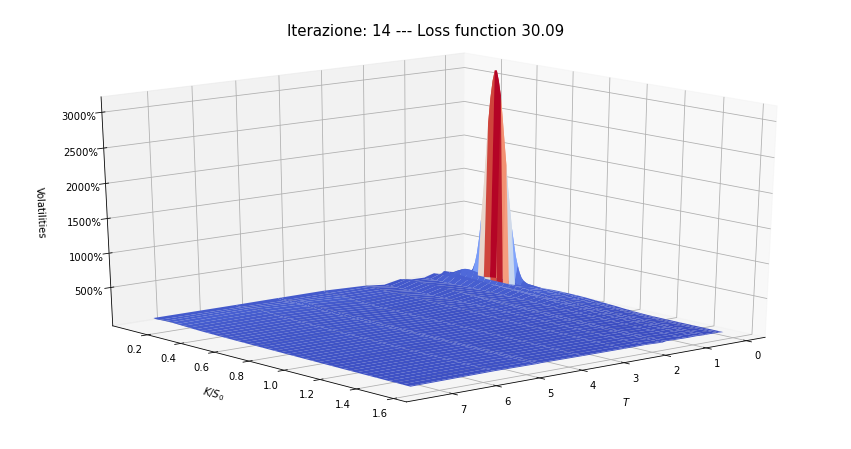

Iterazione: 14---Loss function 30.612511466827176
0


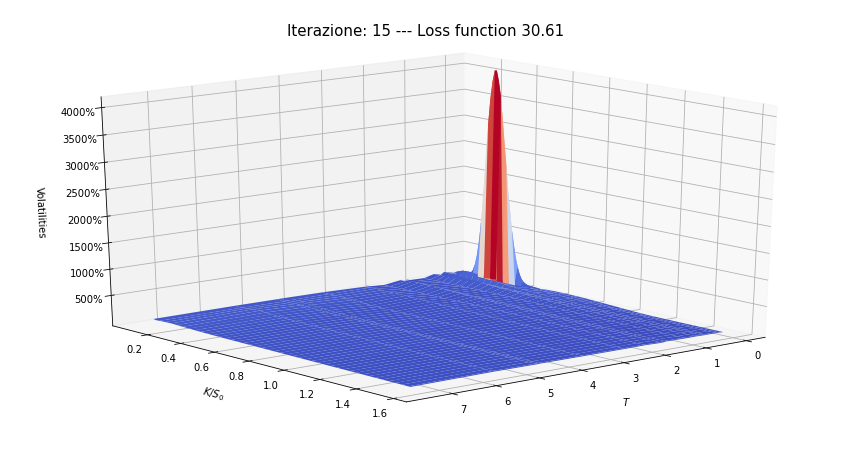

CPU times: user 1h 2min 26s, sys: 1min 58s, total: 1h 4min 24s
Wall time: 32min 19s


In [38]:
%%time
a = Local_Vol_calibrator_f(market_vola,vola_strikes,vola_maturities,F,L_h=100,L_t=100,precision=0.1)

In [41]:
def figure_stampfw_first(x,y,z,spot,title):
    fig = plt.figure(figsize=(15,8))
    ax = fig.add_subplot(111, projection='3d')
    X,Y = np.meshgrid(x,y/spot)
    Z = z

    ax.plot_surface(X, Y,Z , cmap=cm.coolwarm, linewidth=1,antialiased=True)

    ax.set_ylabel(r'$K/S_0$',labelpad=15)
    ax.set_xlabel(r'$T$',labelpad=15)
    ax.set_zlabel('Volatilities',labelpad=13)
    plt.title(title,fontsize=15)
    ax.view_init(20, 50)
    ax.zaxis.set_major_formatter(ticker.PercentFormatter(1))
    plt.savefig("LV_forw_new_first"+title+".pdf",bbox_inches='tight')
    plt.show()

In [44]:
def Local_Vol_calibrator_f_first(market_volatilities,market_strikes,market_maturities,forward_curve,L_h=200,L_t=300,precision=1,max_iter=15):
    t_first = time.perf_counter()
    parameters_in = market_volatilities
    market_vola_forward = forward_volatility(market_volatilities, market_maturities)
    print(np.sum(np.isnan(market_vola_forward)))
    h_min, h_max = set_limits(market_strikes, market_maturities,forward_curve)
    i = 0
    loss = 100
    while loss >= precision:
        sigma_LV = LocalVolatilityCurve(parameters_in,market_strikes,market_maturities)
        calls, h_grid = call_options_pricer(market_maturities, L_t, h_min, h_max, L_h,forward_curve, sigma_LV)
        IV = from_price_to_vola(calls, market_maturities, h_grid)
        IV_forward = forward_volatility(IV, market_maturities)
        IV_coord = back_coordinates(IV,market_maturities,forward_curve,market_strikes,h_grid)
        IV_coord_forward = back_coordinates(IV_forward,market_maturities,forward_curve,market_strikes,h_grid)
        loss = loss_function(IV_coord, market_volatilities)
        parameters_in = new_LV_points(parameters_in,IV_coord_forward,market_vola_forward)
        t2 = time.perf_counter()
        title = 'Iterazione: '+str(i+1)+' --- Loss function '+str(round(loss,2))
        print(title+'---time elapsed: '+str((t2-t_first)/60))
        print(np.sum(np.isnan(IV_coord_forward)))
        figure_stampfw_first(market_maturities,market_strikes,parameters_in,forward_curve.spot,title)
        i = i+1
        if i==max_iter:
            break
    return parameters_in

0
Iterazione: 1 --- Loss function 29.23---time elapsed: 2.1805998379166645
0


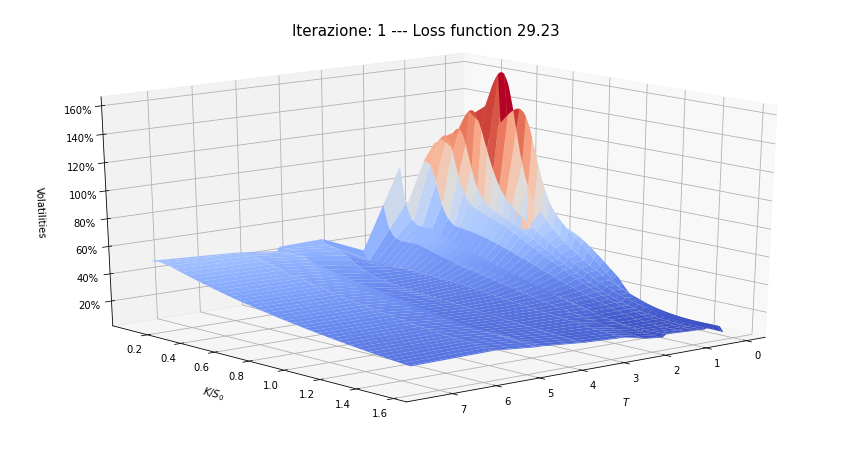

Iterazione: 2 --- Loss function 21.0---time elapsed: 4.602626973683315
0


/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Iterazione: 3 --- Loss function 20.1---time elapsed: 6.916729252033322
0


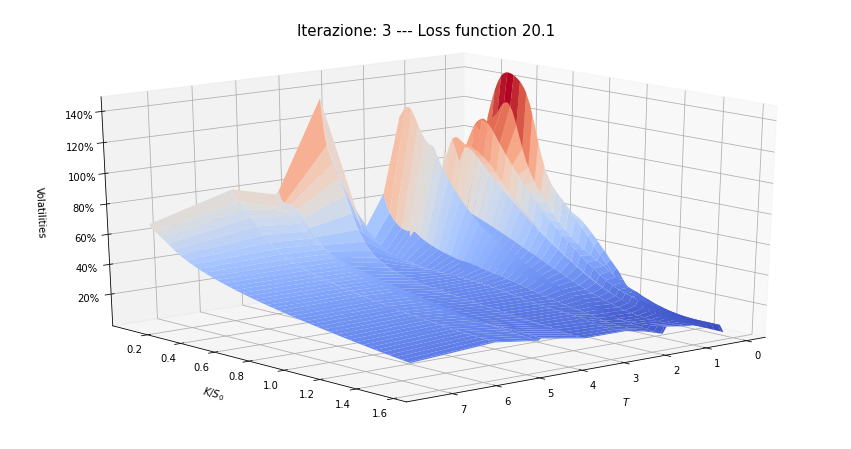

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.


Iterazione: 4 --- Loss function 20.79---time elapsed: 9.202283316833322
0


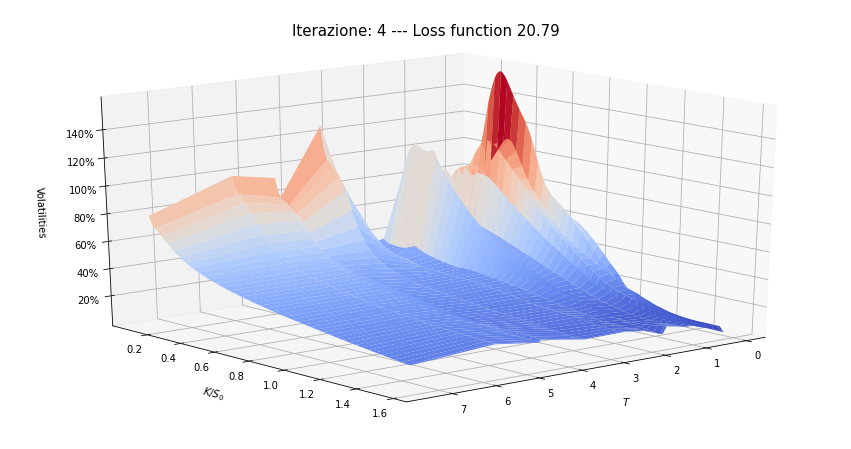

/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in square
  after removing the cwd from sys.path.
/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in subtract
  after removing the cwd from sys.path.
/home/ste/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


Iterazione: 5 --- Loss function 21.06---time elapsed: 11.504243985549996
0


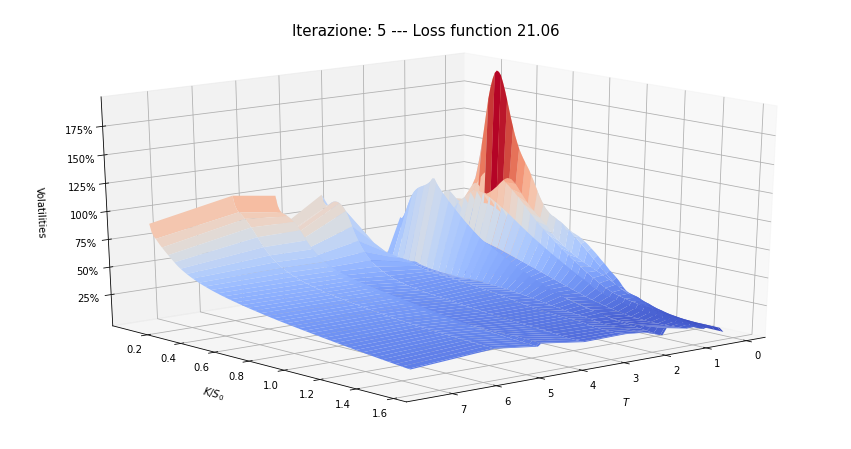

KeyboardInterrupt: 

In [45]:
%%time
a = Local_Vol_calibrator_f_first(market_vola,vola_strikes,vola_maturities,F,L_h=100,L_t=100,precision=0.1)